In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import pandas as pd
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from clean_dataframe import clean_dataframe
from draw_node_amount import *
from draw_nodes import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from isolation_forest import *
from reittien_erottelu import *
from sisään_uloskäynnit import *
from nopeudet import *
from LOF import *

### Read data from database
###### 

In [2]:
%%time
df = database_query("SELECT * FROM SensorData")
alussa = len(df)
df

CPU times: user 5min 30s, sys: 41.2 s, total: 6min 11s
Wall time: 6min 11s


,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0
...,...,...,...,...,...,...
13890901,b'4996252679627069957',b'2020-06-01 03:00:05.469336+00:00',635,1064,0,0
13890902,b'4996252679627069957',b'2020-06-01 03:00:06.47926+00:00',681,760,0,0
13890903,b'4996252679627069957',b'2020-06-01 03:00:08.507118+00:00',622,991,0,0
13890904,b'4996252679627069957',b'2020-06-01 03:00:09.547553+00:00',644,1066,0,0


### Find and delete outliers
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Datan%20Siivous/Z-score%20Outlierit.md


Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in x 10532
uniques in y 7899
uniques in z 3
uniques in q 1
------------------------------
Checking z and q columns

uniques in z [100 400   0]
uniques in q [0]
------------------------------
Number of nodes: 32
------------------------------
Outliers

Data with outliers:  13890906
Ouliers removed:     376791
Data after:  13514115
CPU times: user 35.5 s, sys: 1.02 s, total: 36.5 s
Wall time: 36.5 s


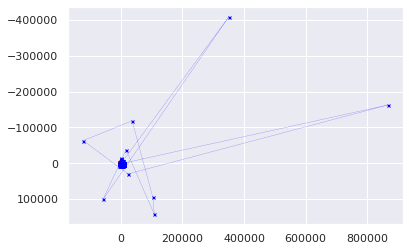

In [3]:
%%time
df = find_outliers(df)
outlierit = len(df)

### Edit timestamps in right form, add hour and weekday columns, and remove useless columns
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Datan%20Siivous/clean_dataframe.md


In [4]:
df = clean_dataframe(df)
aukiolot = len(df)

# LocalOutlierFactor

Starting...
Chunk size:  9711.058
Printing the plot...##################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

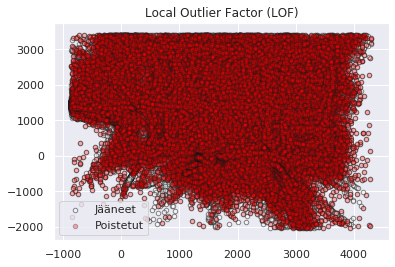

Alkuperäinen data: 9711058
Dataa jäljellä: 9696462
Poistetut outlierit:  14596


In [104]:
df2, outlierit = LOF(df1, 10, 10)
# Draw the deleted and kept points
draw_LOF(df1, outlierit)

# Do some stuff to calculate the amount dropped.
df3 = df1[~df1.isin(df2)].dropna()
print("Alkuperäinen data:",len(df1))
print("Dataa jäljellä:",len(df3))
print("Poistetut outlierit: ",len(df1) - len(df3))
df1 = df3
df_len_LOF = len(df1)

### Calculate and dd distance column

In [5]:
%%time
df = nopeudet(df)
nopeus = len(df)

CPU times: user 1.78 s, sys: 720 ms, total: 2.5 s
Wall time: 2.5 s


### Set distance to match gridsize

In [6]:
%%time
grid_size = 40
x_cut = pd.cut(df['distance'], grid_size,labels=False)
# Laitetaan saadut arvot dataframeen
df['distance'] = x_cut.values

CPU times: user 361 ms, sys: 91.7 ms, total: 453 ms
Wall time: 451 ms


### Discretize x- and y-coordinates, and get grid_id based on discretized coordinates.
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Grid/XY_Diskretisointi.md

In [7]:
df = xy_to_grid(df, df.x, df.y, grid_size)
df

,node_id,timestamp,x,y,dayofweek,current_hour,distance,ero,speedkm,x_grid,y_grid,grid_id
1,1,2020-06-24 15:20:08.620,2870,-344,2,8,1,0.0,inf,28,12,508
2,1,2020-06-24 15:20:09.623,2916,-344,2,8,0,1.0,1.656000,29,12,509
3,1,2020-06-24 15:20:09.623,2894,-254,2,8,0,0.0,inf,29,13,549
4,1,2020-06-24 15:20:10.116,2888,-188,2,8,0,0.0,inf,29,13,549
5,1,2020-06-24 15:20:11.086,2910,-200,2,8,0,0.0,inf,29,13,549
...,...,...,...,...,...,...,...,...,...,...,...,...
9725298,31,2020-09-30 12:24:13.062,2711,-311,2,5,0,3.0,0.170552,27,12,507
9725299,31,2020-09-30 12:24:50.062,2718,-318,2,5,0,37.0,0.009632,27,12,507
9725300,31,2020-09-30 12:25:36.062,2721,-324,2,5,0,46.0,0.005250,27,12,507
9725301,31,2020-09-30 12:26:03.062,2719,-323,2,5,0,27.0,0.002981,27,12,507


### Get entry- and cashier area coordinates. Get grid_ids based on those coordinates.
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Data-analyysi/Sis%C3%A4%C3%A4n_ja_ulosk%C3%A4ynnit.md

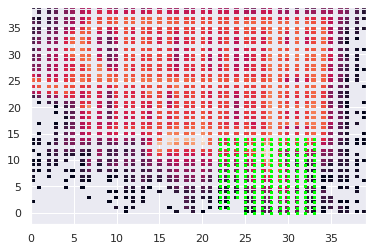

In [8]:
in_x, in_y = sisään(df, 'x_grid', 'y_grid')
out_x, out_y = ulos(df, 'x_grid', 'y_grid')

draw_exits(df, in_x, in_y, out_x, out_y, "x_grid", "y_grid")

# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()


# # Voidaan tarkistaa sijaintien oikeellisuus
# sns.scatterplot(x="x_grid", y="y_grid", data = df)
# sns.scatterplot(x=in_x, y=in_y)
# sns.scatterplot(x=out_x, y=out_y)
# hmax= sns.kdeplot(df.x_grid, df.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
# hmax.collections[3].set_alpha(0)
# plt.show()

### Separate shopping routes from each other
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/Reitit/Reittien_erottelu.md

In [9]:
reitit = erottele_reitit(df, u_in_ID, u_out_ID)
reitit = poista_lyhyet_reitit(reitit, grid_size)
df = reitit_dataframeksi(reitit)
erottelu=len(df)

### Draw routes

In [ ]:
draw_route_grid(df_reitit)

### Remove datapoints from cashier- and entry area. Remove those shopping trips, which were shopping longer than 2 hours. 

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
9,2,1,2020-06-25 15:21:46.646,28,15,628,0,6812.007,3,8
10,2,1,2020-06-25 15:21:47.645,28,15,628,0,6812.007,3,8
11,2,1,2020-06-25 15:21:47.645,28,15,628,0,6812.007,3,8
12,2,1,2020-06-25 15:21:47.647,28,15,628,0,6812.007,3,8
13,2,1,2020-06-25 15:21:50.645,26,15,626,1,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
72,9442,31,2020-09-22 14:41:04.037,19,16,659,0,97.531,1,7
73,9442,31,2020-09-22 14:41:05.038,19,16,659,0,97.531,1,7
75,9442,31,2020-09-22 14:41:06.037,18,16,658,0,97.531,1,7
84,9442,31,2020-09-22 14:41:11.570,1,28,1121,21,97.531,1,7


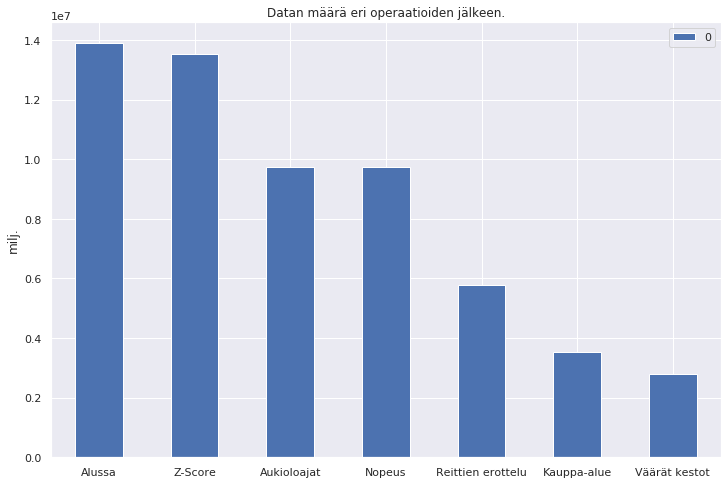

In [10]:
# poistetaan kassa- ja sisääntuloalueella olevat datapisteet
df = df[~df["grid_id"].isin(u_in_ID)]
df = df[~df["grid_id"].isin(u_out_ID)]

alueet = len(df)

# poistetaan reitit, joiden kesto ei ole järkevä
df["kesto"] = df["kesto"].dt.total_seconds()
df = df[df["kesto"] < 7200]
df = df[df["kesto"] > 0]

kestot = len(df)

pd.DataFrame.from_dict([{"Alussa":alussa, "Z-Score":outlierit, "Aukioloajat":aukiolot,"Nopeus":nopeus, "Reittien erottelu":erottelu, "Kauppa-alue":alueet, "Väärät kestot":kestot}]).T.plot.bar(figsize=(12,8), rot=360, ylabel="milj.", title="Datan määrä eri operaatioiden jälkeen.")
df

In [11]:
df

,ajokerta,node_id,timestamp,x,y,grid_id,distance,kesto,dayofweek,current_hour
9,2,1,2020-06-25 15:21:46.646,28,15,628,0,6812.007,3,8
10,2,1,2020-06-25 15:21:47.645,28,15,628,0,6812.007,3,8
11,2,1,2020-06-25 15:21:47.645,28,15,628,0,6812.007,3,8
12,2,1,2020-06-25 15:21:47.647,28,15,628,0,6812.007,3,8
13,2,1,2020-06-25 15:21:50.645,26,15,626,1,6812.007,3,8
...,...,...,...,...,...,...,...,...,...,...
72,9442,31,2020-09-22 14:41:04.037,19,16,659,0,97.531,1,7
73,9442,31,2020-09-22 14:41:05.038,19,16,659,0,97.531,1,7
75,9442,31,2020-09-22 14:41:06.037,18,16,658,0,97.531,1,7
84,9442,31,2020-09-22 14:41:11.570,1,28,1121,21,97.531,1,7


### Save cleaned shopping trips to database
###### https://gitlab.dclabra.fi/ryhm-fox/projekti-2-team-fox/-/blob/master/Dokumentaatio/write_df_to_dataframe.md

In [ ]:
for i in df.ajokerta.unique():
    print(df[df["ajokerta"] == i].distance.sum()/ df[df["ajokerta"] == i].kesto.mean())
# df
df.ajokerta.unique()

In [12]:
write_df_to_mariadb(df, "REITIT")

Existing table found. Prepairing to Drop Table named REITIT...


Continue? yes/no:  yes


Done! Prepairing to write dataframe to REITIT
Writing data 1 / 14
Writing data 2 / 14
Writing data 3 / 14
Writing data 4 / 14
Writing data 5 / 14
Writing data 6 / 14
Writing data 7 / 14
Writing data 8 / 14
Writing data 9 / 14
Writing data 10 / 14
Writing data 11 / 14
Writing data 12 / 14
Writing data 13 / 14
Writing data 14 / 14
Done!
